# DARTS
Examples of DARTS (https://github.com/unit8co/darts) library usage.

Examples are taken from https://github.com/unit8co/darts/blob/master/examples, adding some minor modifications.

In [43]:
!pip install darts
!pip install lightgbm

# 1. Quickstart


In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.datasets import AirPassengersDataset

## 1.1. Data visualization

<Axes: xlabel='Month'>

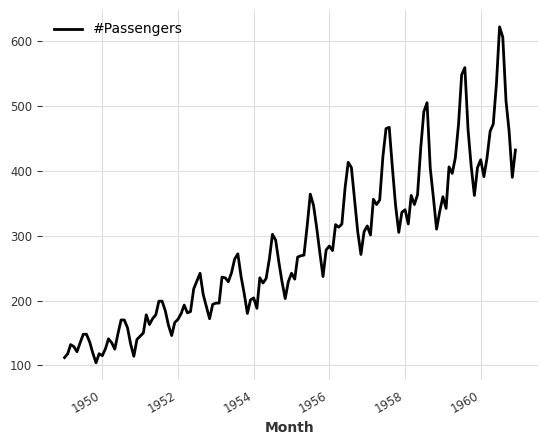

In [3]:
# Load data
series = AirPassengersDataset().load()
series.plot()

In [11]:
# Show object structure
series.head(2)

<TimeSeries (DataArray) (Month: 2, component: 1, sample: 1)>
array([[[112.]],

       [[118.]]])
Coordinates:
  * Month      (Month) datetime64[ns] 1949-01-01 1949-02-01
  * component  (component) object '#Passengers'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

<Axes: xlabel='Month'>

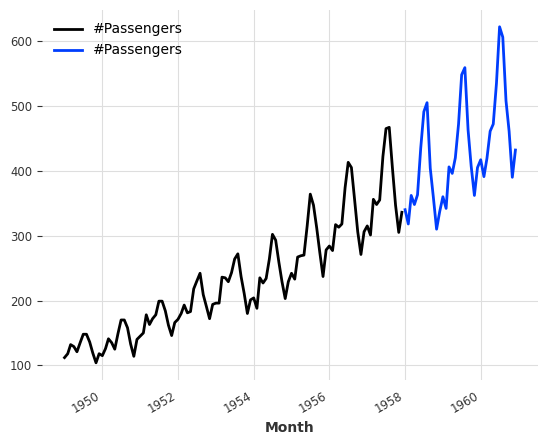

In [4]:
series1, series2 = series.split_after(0.75)
series1.plot()
series2.plot()

<Axes: xlabel='Month'>

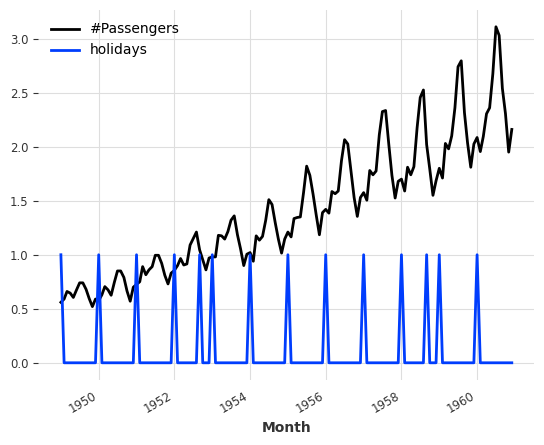

In [5]:
(series / 200).add_holidays("US").plot()

<Axes: xlabel='time'>

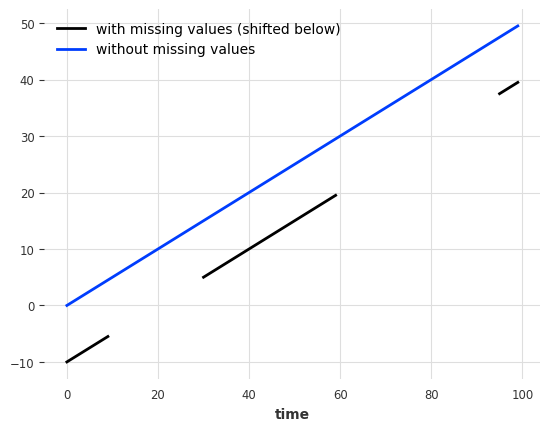

In [6]:
from darts.utils.missing_values import fill_missing_values

values = np.arange(50, step=0.5)
values[10:30] = np.nan
values[60:95] = np.nan
series_ = TimeSeries.from_values(values)

(series_ - 10).plot(label="with missing values (shifted below)")
fill_missing_values(series_).plot(label="without missing values")

## 1.2. Baseline models

<Axes: xlabel='Month'>

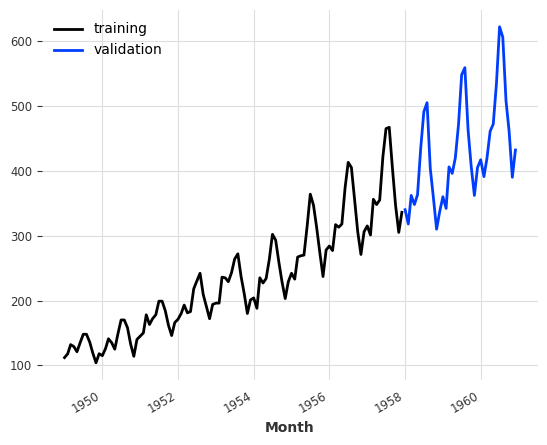

In [7]:
train, val = series.split_before(pd.Timestamp("19580101"))
train.plot(label="training")
val.plot(label="validation")

In [9]:
display(train.head(2))

<TimeSeries (DataArray) (Month: 2, component: 1, sample: 1)>
array([[[112.]],

       [[118.]]])
Coordinates:
  * Month      (Month) datetime64[ns] 1949-01-01 1949-02-01
  * component  (component) object '#Passengers'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

<Axes: xlabel='Month'>

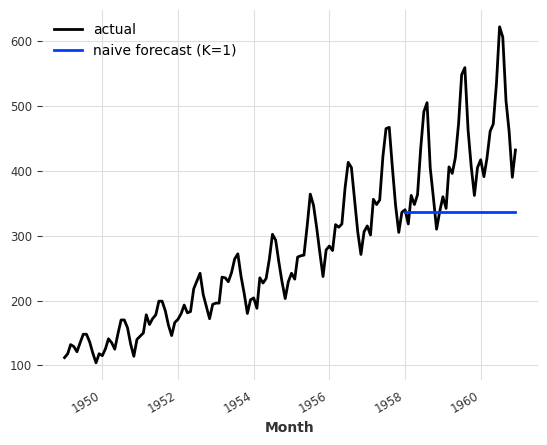

In [8]:
from darts.models import NaiveSeasonal

naive_model = NaiveSeasonal(K=1)
naive_model.fit(train)
naive_forecast = naive_model.predict(36)

series.plot(label="actual")
naive_forecast.plot(label="naive forecast (K=1)")

There is seasonality of order 12.


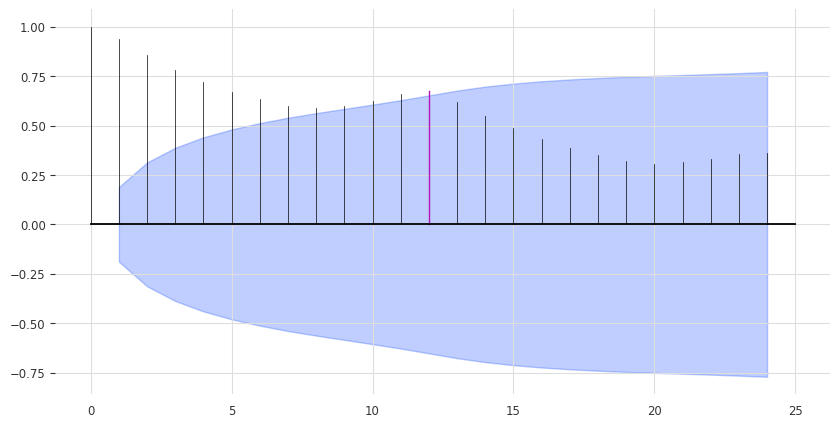

In [13]:
# Inspect seasonality & improve model baseline
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(train, m=12, alpha=0.05)

k = 1
for m in range(2, 25):
    is_seasonal, period = check_seasonality(train, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))
        k = period

<Axes: xlabel='Month'>

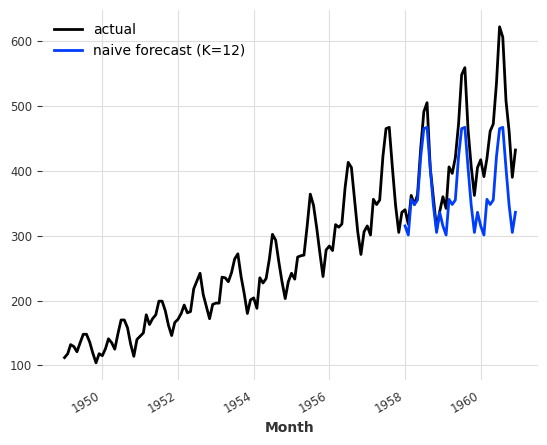

In [15]:
seasonal_model = NaiveSeasonal(K=k)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(36)

series.plot(label="actual")
seasonal_forecast.plot(label=f"naive forecast (K={k})")

<Axes: xlabel='Month'>

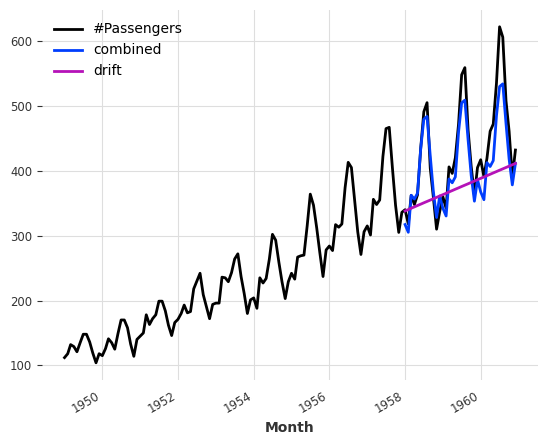

In [16]:
# Improve baseline - Include Trend
from darts.models import NaiveDrift

drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(36)

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

series.plot()
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")

In [18]:
# Error metrics
from darts.metrics import mape

print(
    "Mean absolute percentage error for the combined naive drift + seasonal: {:.2f}%.".format(
        mape(series, combined_forecast)
    )
)

Mean absolute percentage error for the combined naive drift + seasonal: 5.66%.


In [19]:
# Try other models
from darts.models import ExponentialSmoothing, TBATS, AutoARIMA, Theta

def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    print("model {} obtains MAPE: {:.2f}%".format(model, mape(val, forecast)))


eval_model(ExponentialSmoothing())
eval_model(TBATS())
eval_model(AutoARIMA())
eval_model(Theta())

model ExponentialSmoothing() obtains MAPE: 5.11%
model TBATS() obtains MAPE: 5.87%
model AutoARIMA() obtains MAPE: 11.65%
model Theta() obtains MAPE: 8.15%


The MAPE is: 4.40, with theta = -3.5102040816326543.


<Axes: xlabel='Month'>

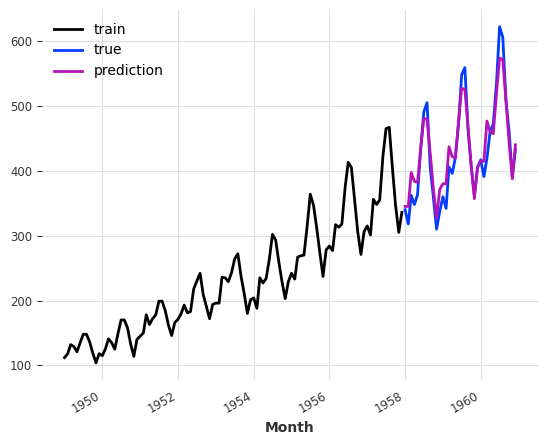

In [22]:
# Hyperparameter search

# Search for the best theta parameter, by trying 50 different values
thetas = 2 - np.linspace(-10, 10, 50)

best_mape = float("inf")
best_theta = 0

for theta in thetas:
    model = Theta(theta)
    model.fit(train)
    pred_theta = model.predict(len(val))
    res = mape(val, pred_theta)

    if res < best_mape:
        best_mape = res
        best_theta = theta

# Eval model
best_theta_model = Theta(best_theta)
best_theta_model.fit(train)
pred_best_theta = best_theta_model.predict(len(val))

print(
    "The MAPE is: {:.2f}, with theta = {}.".format(
        mape(val, pred_best_theta), best_theta
    )
)

# Plot results
train.plot(label="train")
val.plot(label="true")
pred_best_theta.plot(label="prediction")

100%|██████████| 57/57 [00:03<00:00, 17.88it/s]


MAPE = 7.70%


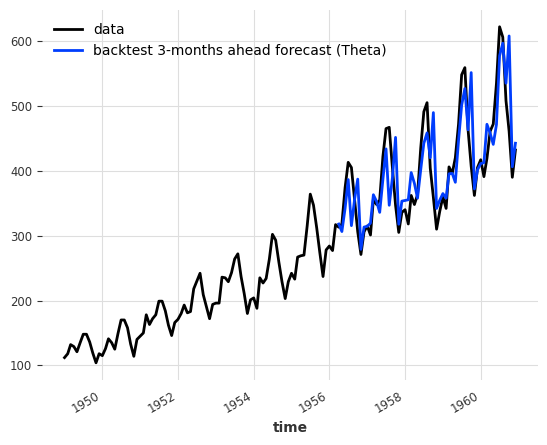

In [23]:
# Backtesting: performance we would have obtained if we had been using this model historically

historical_fcast_theta = best_theta_model.historical_forecasts(
    series, start=0.6, forecast_horizon=3, verbose=True
)

series.plot(label="data")
historical_fcast_theta.plot(label="backtest 3-months ahead forecast (Theta)")
print("MAPE = {:.2f}%".format(mape(historical_fcast_theta, series)))

100%|██████████| 57/57 [00:01<00:00, 42.88it/s]


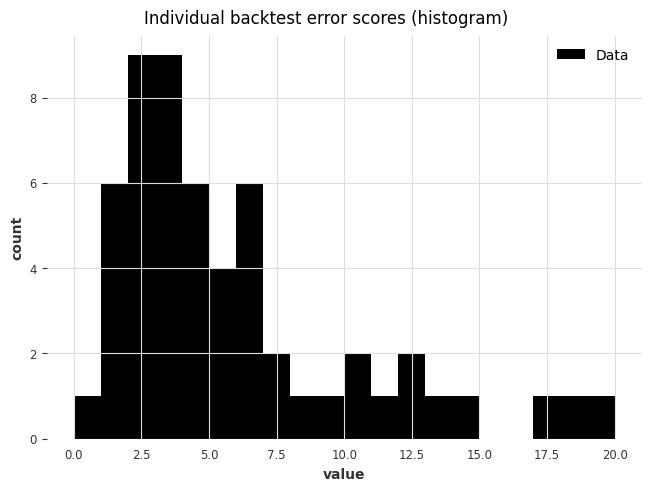

In [24]:
best_theta_model = Theta(best_theta)

raw_errors = best_theta_model.backtest(
    series, start=0.6, forecast_horizon=3, metric=mape, reduction=None, verbose=True
)

from darts.utils.statistics import plot_hist

plot_hist(
    raw_errors,
    bins=np.arange(0, max(raw_errors), 1),
    title="Individual backtest error scores (histogram)",
)

100%|██████████| 57/57 [00:05<00:00, 10.72it/s]


MAPE = 4.45%


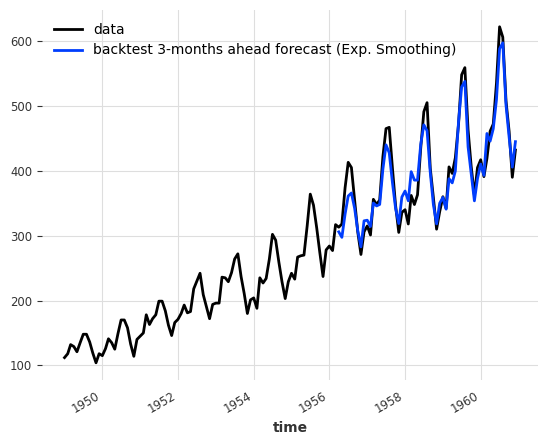

In [25]:
# Trying another model
model_es = ExponentialSmoothing(seasonal_periods=12)
historical_fcast_es = model_es.historical_forecasts(
    series, start=0.6, forecast_horizon=3, verbose=True
)

series.plot(label="data")
historical_fcast_es.plot(label="backtest 3-months ahead forecast (Exp. Smoothing)")
print("MAPE = {:.2f}%".format(mape(historical_fcast_es, series)))

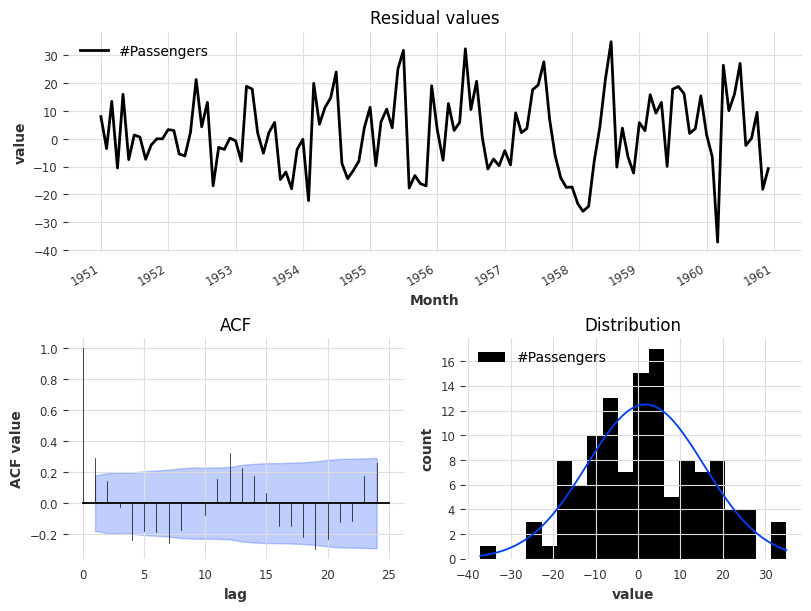

In [27]:
from darts.utils.statistics import plot_residuals_analysis

plot_residuals_analysis(model_es.residuals(series))

## 1.3. ML models

<Axes: xlabel='Month'>

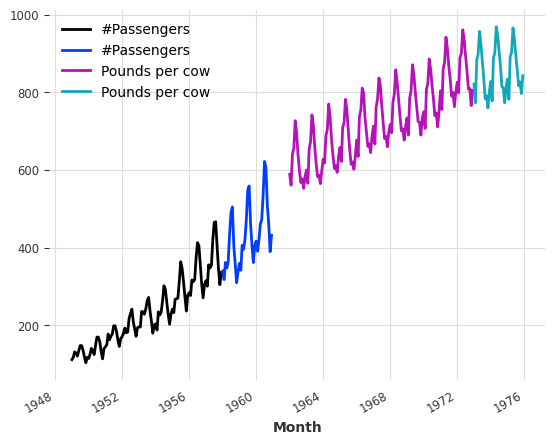

In [28]:
# Get two time series

from darts.datasets import AirPassengersDataset, MonthlyMilkDataset

series_air = AirPassengersDataset().load().astype(np.float32)
series_milk = MonthlyMilkDataset().load().astype(np.float32)

# set aside last 36 months of each series as validation set:
train_air, val_air = series_air[:-36], series_air[-36:]
train_milk, val_milk = series_milk[:-36], series_milk[-36:]

train_air.plot()
val_air.plot()
train_milk.plot()
val_milk.plot()

<Axes: xlabel='Month'>

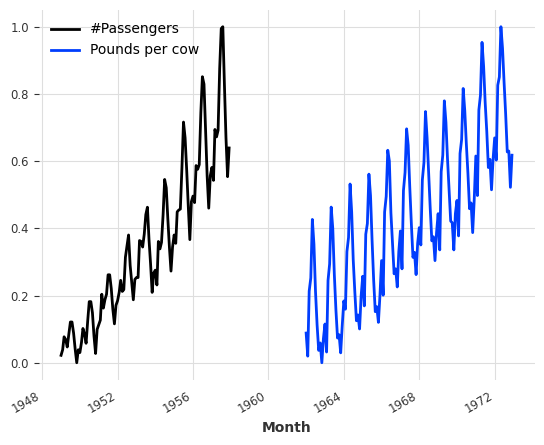

In [29]:
# Scale the series

from darts.dataprocessing.transformers import Scaler

scaler = Scaler()
train_air_scaled, train_milk_scaled = scaler.fit_transform([train_air, train_milk])

train_air_scaled.plot()
train_milk_scaled.plot()

### NBEATS

In [30]:
# Using NBEATS

from darts.models import NBEATSModel

model = NBEATSModel(input_chunk_length=24, output_chunk_length=12, random_state=42)

model.fit([train_air_scaled, train_milk_scaled], epochs=50, verbose=True);

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.2 M 
---------------------------------------------------
6.2 M     Trainable params
1.4 K     Non-trainable params
6.2 M     Total params
24.787    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: xlabel='Month'>

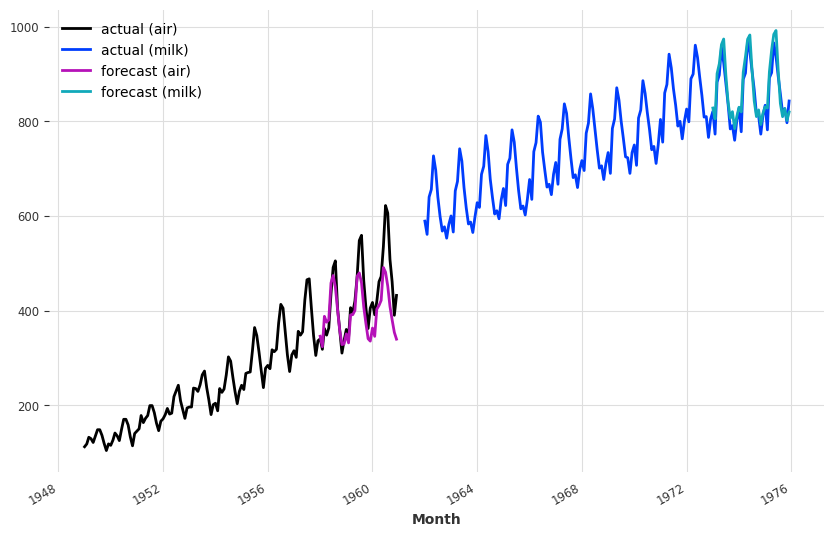

In [31]:
pred_air = model.predict(series=train_air_scaled, n=36)
pred_milk = model.predict(series=train_milk_scaled, n=36)

# scale back:
pred_air, pred_milk = scaler.inverse_transform([pred_air, pred_milk])

plt.figure(figsize=(10, 6))
series_air.plot(label="actual (air)")
series_milk.plot(label="actual (milk)")
pred_air.plot(label="forecast (air)")
pred_milk.plot(label="forecast (milk)")

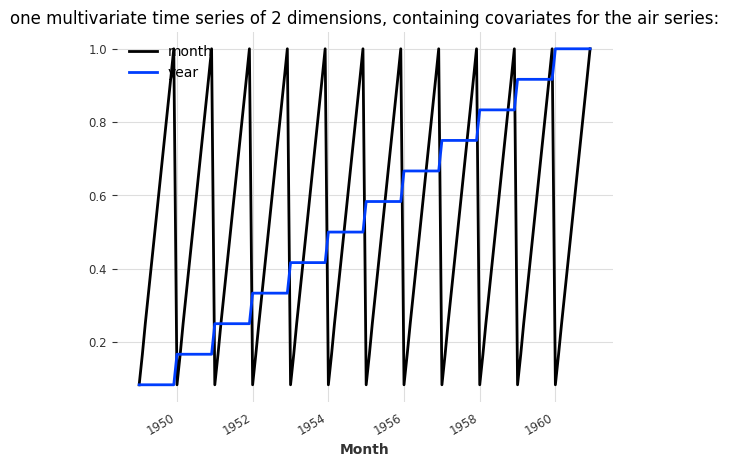

In [32]:
# Include Covariates

from darts import concatenate
from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr

air_covs = concatenate(
    [
        dt_attr(series_air.time_index, "month", dtype=np.float32) / 12,
        (dt_attr(series_air.time_index, "year", dtype=np.float32) - 1948) / 12,
    ],
    axis="component",
)

milk_covs = concatenate(
    [
        dt_attr(series_milk.time_index, "month", dtype=np.float32) / 12,
        (dt_attr(series_milk.time_index, "year", dtype=np.float32) - 1962) / 13,
    ],
    axis="component",
)

air_covs.plot()
plt.title(
    "one multivariate time series of 2 dimensions, containing covariates for the air series:"
);

In [35]:
# View datasets
display(milk_covs.head())
display(air_covs.head())

<TimeSeries (DataArray) (Month: 5, component: 2, sample: 1)>
array([[[0.08333334],
        [0.        ]],

       [[0.16666667],
        [0.        ]],

       [[0.25      ],
        [0.        ]],

       [[0.33333334],
        [0.        ]],

       [[0.41666666],
        [0.        ]]], dtype=float32)
Coordinates:
  * Month      (Month) datetime64[ns] 1962-01-01 1962-02-01 ... 1962-05-01
  * component  (component) object 'month' 'year'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

<TimeSeries (DataArray) (Month: 5, component: 2, sample: 1)>
array([[[0.08333334],
        [0.08333334]],

       [[0.16666667],
        [0.08333334]],

       [[0.25      ],
        [0.08333334]],

       [[0.33333334],
        [0.08333334]],

       [[0.41666666],
        [0.08333334]]], dtype=float32)
Coordinates:
  * Month      (Month) datetime64[ns] 1949-01-01 1949-02-01 ... 1949-05-01
  * component  (component) object 'month' 'year'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [36]:
# Use covariates within the model
model = NBEATSModel(input_chunk_length=24, output_chunk_length=12, random_state=42)

model.fit(
    [train_air_scaled, train_milk_scaled],
    past_covariates=[air_covs, milk_covs],
    epochs=50,
    verbose=True,
);

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.6 M 
---------------------------------------------------
6.6 M     Trainable params
1.7 K     Non-trainable params
6.6 M     Total params
26.314    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: xlabel='Month'>

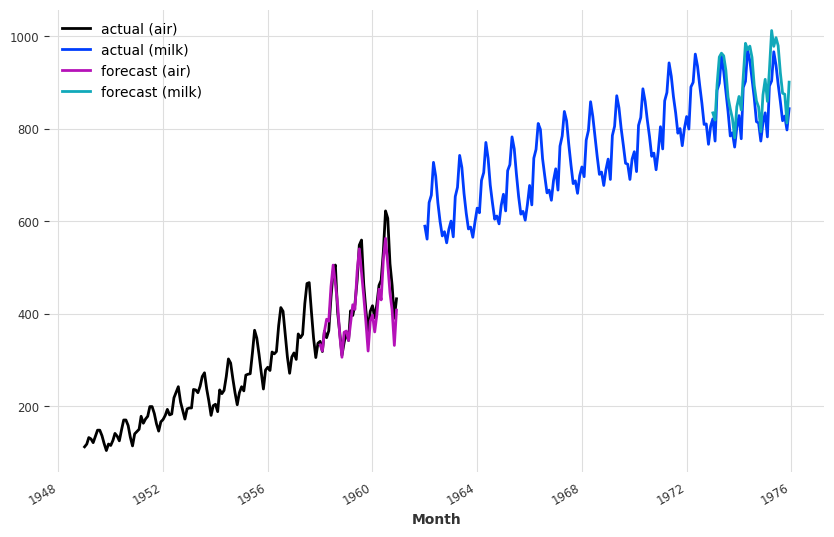

In [37]:
pred_air = model.predict(series=train_air_scaled, past_covariates=air_covs, n=36)
pred_milk = model.predict(series=train_milk_scaled, past_covariates=milk_covs, n=36)

# scale back:
pred_air, pred_milk = scaler.inverse_transform([pred_air, pred_milk])

plt.figure(figsize=(10, 6))
series_air.plot(label="actual (air)")
series_milk.plot(label="actual (milk)")
pred_air.plot(label="forecast (air)")
pred_milk.plot(label="forecast (milk)")

### Regression model wrapper

In [38]:
# Wrapper around sklearn (or similar) models
from darts.models import RegressionModel
from sklearn.linear_model import BayesianRidge

model = RegressionModel(lags=72, lags_future_covariates=[-6, 0], model=BayesianRidge())

model.fit(
    [train_air_scaled, train_milk_scaled], future_covariates=[air_covs, milk_covs]
);

<Axes: xlabel='Month'>

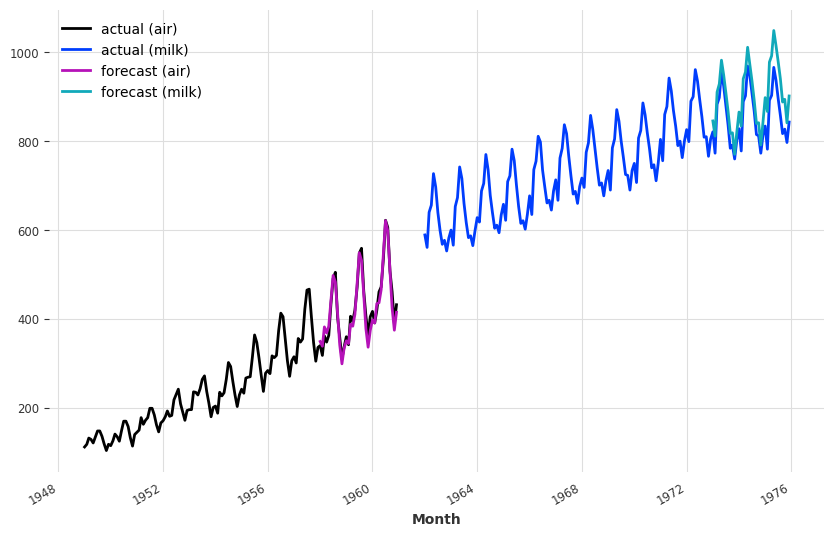

In [39]:
pred_air, pred_milk = model.predict(
    series=[train_air_scaled, train_milk_scaled],
    future_covariates=[air_covs, milk_covs],
    n=36,
)

# scale back:
pred_air, pred_milk = scaler.inverse_transform([pred_air, pred_milk])

plt.figure(figsize=(10, 6))
series_air.plot(label="actual (air)")
series_milk.plot(label="actual (milk)")
pred_air.plot(label="forecast (air)")
pred_milk.plot(label="forecast (milk)")

In [40]:
mape([series_air, series_milk], [pred_air, pred_milk])

[3.417101874947548, 5.283059179782867]

In [41]:
mape([series_air, series_milk], [pred_air, pred_milk], inter_reduction=np.mean)

4.350080527365208

100%|██████████| 57/57 [00:02<00:00, 25.92it/s]


MAPE = 3.66


<Axes: xlabel='time'>

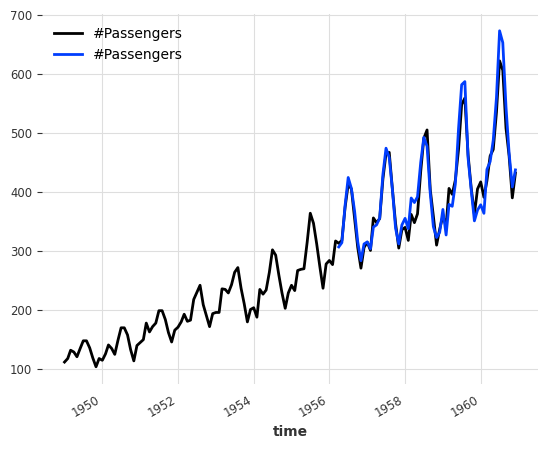

In [42]:
# Backtest
bayes_ridge_model = RegressionModel(
    lags=72, lags_future_covariates=[0], model=BayesianRidge()
)

backtest = bayes_ridge_model.historical_forecasts(
    series_air, future_covariates=air_covs, start=0.6, forecast_horizon=3, verbose=True
)

print("MAPE = %.2f" % (mape(backtest, series_air)))
series_air.plot()
backtest.plot()

In [52]:
def pipeline_model(
    series_target_1,
    series_target_2,
    series_sc_target_1,
    series_sc_target_2,
    series_name_1,
    series_name_2,
    series_covs_1,
    series_cov_2,
    scaler,
    reg_model
    ):

  # Train model
  model = RegressionModel(
      lags=72,
      lags_future_covariates=[-6, 0],
      model=reg_model()
      )
  model.fit(
      [series_sc_target_1, series_sc_target_2], future_covariates=[series_covs_1, series_cov_2]
  )

  # Get predictions
  pred_series_1, pred_series_2 = model.predict(
      series=[series_sc_target_1, series_sc_target_2],
      future_covariates=[series_covs_1, series_cov_2],
      n=36,
  )

  # Scale back
  pred_series_1, pred_series_2 = scaler.inverse_transform([pred_series_1, pred_series_2])

  plt.figure(figsize=(10, 6))
  series_target_1.plot(label=f"actual ({series_name_1})")
  series_target_2.plot(label=f"actual ({series_name_2})")
  pred_series_1.plot(label=f"forecast ({series_name_1})")
  pred_series_2.plot(label=f"forecast ({series_name_2})")

  print("MAPE:", mape([series_target_1, series_target_2], [pred_series_1, pred_series_2]))

  # Backtest - series 1
  model = RegressionModel(
      lags=72,
      lags_future_covariates=[0],
      model=reg_model()
  )

  backtest = model.historical_forecasts(
      series_target_1,
      future_covariates=series_covs_1,
      start=0.6,
      forecast_horizon=3,
      verbose=True
  )

  print("MAPE = %.2f" % (mape(backtest, series_target_1)))
  series_target_1.plot()
  backtest.plot()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2354
[LightGBM] [Info] Number of data points in the train set: 96, number of used features: 76
[LightGBM] [Info] Start training from score 0.603419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

MAPE: [11.110402861189247, 5.956870767152427]


  4%|▎         | 2/57 [00:00<00:03, 14.75it/s]

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 13, number of used features: 0
[LightGBM] [Info] Start training from score 284.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the sp

  7%|▋         | 4/57 [00:00<00:03, 14.57it/s]

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 16, number of used features: 0
[LightGBM] [Info] Start training from score 287.437500
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the sp

 11%|█         | 6/57 [00:00<00:03, 14.42it/s]

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements


 14%|█▍        | 8/57 [00:00<00:03, 14.65it/s]

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 19, number of used features: 0
[LightGBM] [Info] Start training from score 300.210526
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the sp

 21%|██        | 12/57 [00:00<00:02, 15.01it/s]

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

 28%|██▊       | 16/57 [00:01<00:04,  9.21it/s]

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

 32%|███▏      | 18/57 [00:01<00:03, 10.45it/s]

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

 39%|███▊      | 22/57 [00:01<00:02, 12.43it/s]

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

 42%|████▏     | 24/57 [00:01<00:02, 12.82it/s]

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 36, number of used features: 0
[LightGBM] [Info] Start training from score 326.888889
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the sp

 49%|████▉     | 28/57 [00:02<00:02, 13.50it/s]

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 39, number of used features: 0
[LightGBM] [Info] Start training from score 327.897436
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the sp

 53%|█████▎    | 30/57 [00:02<00:02, 13.14it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1009
[LightGBM] [Info] Number of data points in the train set: 42, number of used features: 69
[LightGBM] [Info] Start training from score 331.761905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

 60%|█████▉    | 34/57 [00:02<00:01, 13.29it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000065 secon

 63%|██████▎   | 36/57 [00:02<00:01, 13.35it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 70%|███████   | 40/57 [00:03<00:01, 13.44it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 74%|███████▎  | 42/57 [00:03<00:01, 13.14it/s]


[LightGBM] [Info] Total Bins 1315
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 74
[LightGBM] [Info] Start training from score 344.603774
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

 77%|███████▋  | 44/57 [00:03<00:01, 12.88it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 84%|████████▍ | 48/57 [00:03<00:00, 12.83it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 88%|████████▊ | 50/57 [00:03<00:00, 12.68it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1499
[LightGBM] [Info] Number of data points in the train set: 61, number of used features: 74
[LightGBM] [Info] Start training from score 358.967213
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

 91%|█████████ | 52/57 [00:04<00:00, 12.28it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 95%|█████████▍| 54/57 [00:04<00:00, 12.03it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1614
[LightGBM] [Info] Number of data points in the train set: 66, number of used features: 74
[LightGBM] [Info] Start training from score 366.287879
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

100%|██████████| 57/57 [00:04<00:00, 12.45it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

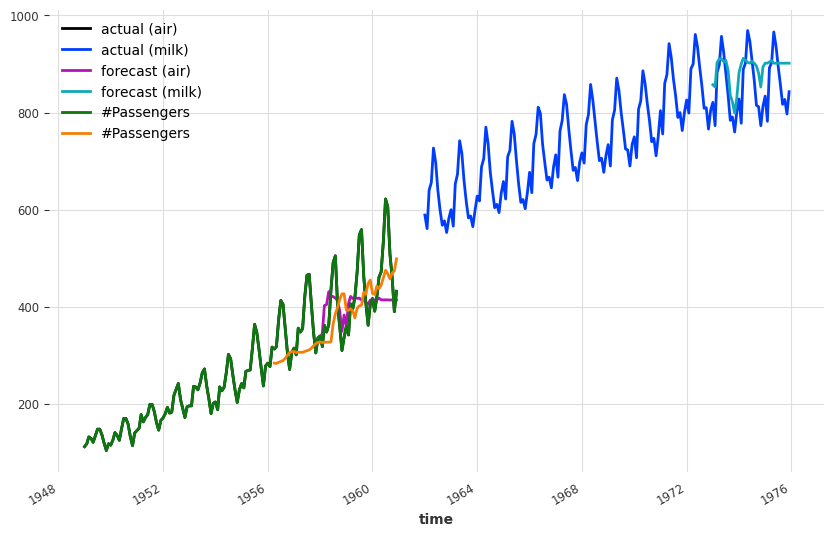

In [54]:
# Use LightGBM
from lightgbm import LGBMRegressor

pipeline_model(
    series_target_1=series_air,
    series_target_2=series_milk,
    series_sc_target_1=train_air_scaled,
    series_sc_target_2=train_milk_scaled,
    series_name_1="air",
    series_name_2="milk",
    series_covs_1=air_covs,
    series_cov_2=milk_covs,
    scaler=scaler,
    reg_model=LGBMRegressor
    )

MAPE: [8.038248866796494, 6.649124622344971]


100%|██████████| 57/57 [00:00<00:00, 60.55it/s]


MAPE = 4.68


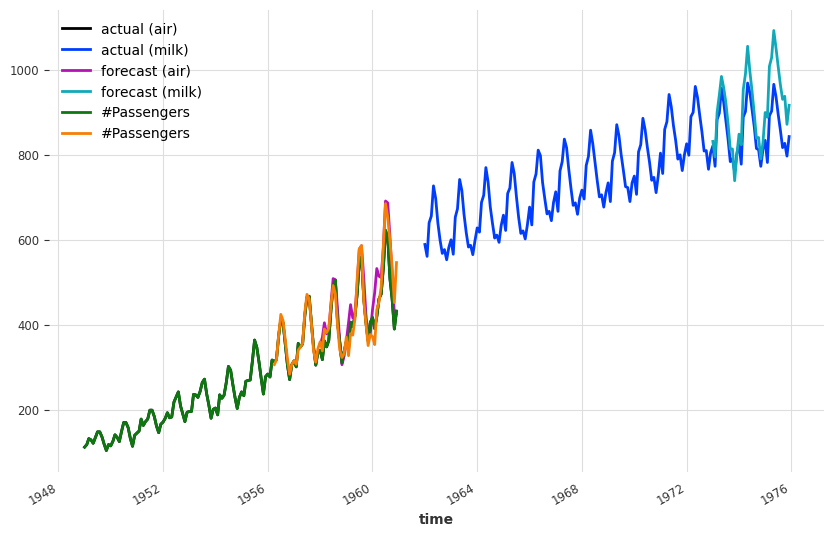

In [53]:
# Use Linear Regression
from sklearn.linear_model import LinearRegression

pipeline_model(
    series_target_1=series_air,
    series_target_2=series_milk,
    series_sc_target_1=train_air_scaled,
    series_sc_target_2=train_milk_scaled,
    series_name_1="air",
    series_name_2="milk",
    series_covs_1=air_covs,
    series_cov_2=milk_covs,
    scaler=scaler,
    reg_model=LinearRegression
    )

### Probabilistic forecasts

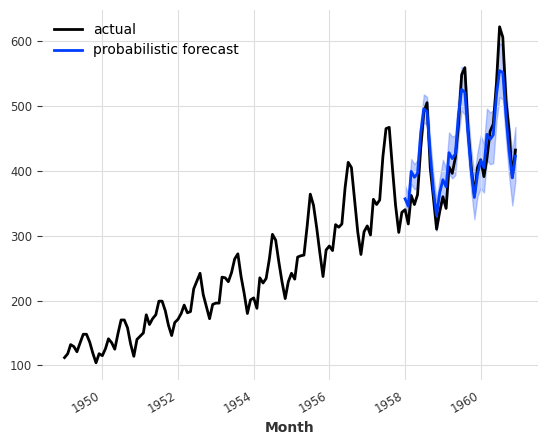

In [55]:
model_es = ExponentialSmoothing()
model_es.fit(train)
probabilistic_forecast = model_es.predict(len(val), num_samples=500)

series.plot(label="actual")
probabilistic_forecast.plot(label="probabilistic forecast")
plt.legend()
plt.show()

In [56]:
probabilistic_forecast.head(2)

<TimeSeries (DataArray) (Month: 2, component: 1, sample: 500)>
array([[[377.55991095, 361.92076704, 368.5550806 , 383.02762069,
         378.74676148, 346.12636688, 368.2265695 , 355.59681067,
         356.14879056, 362.04049244, 358.98403244, 374.00782273,
         366.05881415, 358.72754275, 362.42192346, 361.15843912,
         374.46425444, 354.97989928, 360.92215263, 347.53883853,
         328.05841938, 364.82708952, 367.24443581, 348.82229543,
         383.35856107, 340.65582558, 357.85704397, 355.18600343,
         374.90801075, 374.18079835, 359.10906181, 361.66856429,
         347.15253106, 334.61949132, 353.34300763, 359.12513265,
         371.43951704, 371.11947666, 352.89105818, 353.86598915,
         345.30908901, 341.04967492, 337.767355  , 379.70097631,
         351.48841077, 352.30916065, 342.96713755, 366.24746873,
         338.8265452 , 354.89295986, 347.06445878, 361.76878151,
         351.47519037, 343.79459874, 357.00920022, 362.24383263,
         358.09507427, 360.80065553, 350.05887954, 353.17297027,
         349.62156497, 353.20952562, 348.0083867 , 337.53788209,
         359.36681468, 352.72531959, 338.63963504, 362.63885899,
         346.92878906, 357.92798599, 365.69249106, 358.81133894,
         370.39732421, 343.1731858 , 361.9458149 , 349.47995743,
         347.34733132, 350.69495578, 353.75992626, 357.97637413,
...
         333.59997538, 362.12553678, 354.9939556 , 348.53017587,
         345.96379434, 372.91755092, 345.3605941 , 334.97036461,
         348.36339958, 363.46678363, 362.74208847, 338.78329555,
         351.85290829, 330.81401565, 339.45209931, 337.08968401,
         336.63639739, 365.11722791, 339.03607457, 339.94939994,
         348.87936505, 357.369747  , 351.08993934, 378.01875982,
         347.48097747, 348.45594945, 350.29488501, 359.50307727,
         349.38729864, 344.17017765, 331.92494341, 350.98033673,
         363.21968679, 341.91658648, 352.85926793, 354.45075811,
         354.37430799, 330.26587574, 373.30082037, 331.00720419,
         340.14130631, 353.76384728, 347.96051384, 355.85836465,
         338.68658859, 351.89538844, 343.20010408, 361.53484869,
         347.1598965 , 355.6779555 , 332.48123681, 355.37959102,
         347.61457816, 359.70920942, 373.91166735, 345.16034677,
         344.95225231, 333.3766526 , 347.41719347, 342.8650832 ,
         352.15932333, 347.12091756, 339.06225188, 356.80785034,
         337.54488853, 343.15462522, 345.51446819, 355.7157671 ,
         361.57296586, 342.9783843 , 347.91743018, 346.8646258 ,
         339.81559437, 352.3114557 , 356.88385763, 350.34191744,
         341.65265484, 345.42240823, 329.73537808, 341.49010194]]])
Coordinates:
  * Month      (Month) datetime64[ns] 1958-01-01 1958-02-01
  * component  (component) object '#Passengers'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

<Axes: xlabel='Month'>

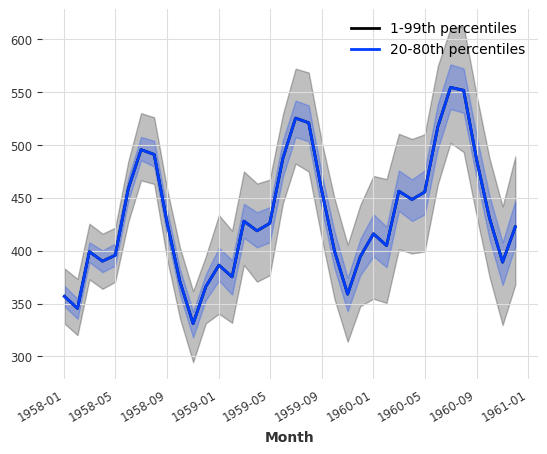

In [57]:
probabilistic_forecast.plot(low_quantile=0.01, high_quantile=0.99, label="1-99th percentiles")
probabilistic_forecast.plot(low_quantile=0.2, high_quantile=0.8, label="20-80th percentiles")

In [58]:
from darts.metrics import rho_risk

print("MAPE of median forecast: %.2f" % mape(series_air, probabilistic_forecast))
for rho in [0.05, 0.1, 0.5, 0.9, 0.95]:
    rr = rho_risk(series_air, probabilistic_forecast, rho=rho)
    print("rho-risk at quantile %.2f: %.2f" % (rho, rr))

MAPE of median forecast: 5.11
rho-risk at quantile 0.05: 0.00
rho-risk at quantile 0.10: 0.01
rho-risk at quantile 0.50: 0.01
rho-risk at quantile 0.90: 0.01
rho-risk at quantile 0.95: 0.01
